In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
sns.set_theme()

In [2]:
lotus = pd.read_csv("../data/230106_frozen_metadata.csv.gz", low_memory=False)
lotus = lotus.rename(columns={'organism_name': 'species', 'structure_smiles_2D': 'molecule'})

In [3]:
directory = '../out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [4]:
pivot_df = df.pivot_table(index='species', columns='molecule', values='prob')
del df

In [5]:
#pivot_df

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [7]:
# Standardize the data (important for PCA)
scaler = StandardScaler()
species_std = scaler.fit_transform(pivot_df)

Text(0, 0.5, 'PC2 (13.23% of variance)')

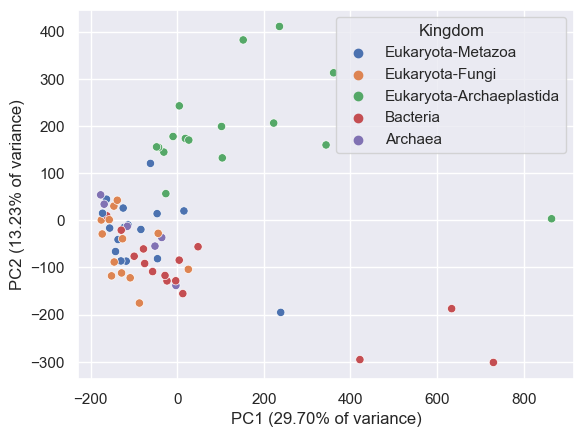

In [8]:
# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(species_std)

# Create a DataFrame from PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['species'] = pivot_df.index  # Add species column from the index of pivot_df

# Merge the kingdom information into the PCA results dataframe
pca_df = pd.merge(pca_df, lotus[['species',
                                 'organism_taxonomy_02kingdom',
                                'organism_taxonomy_01domain']], on='species', how='left').drop_duplicates()
pca_df['organism_taxonomy_02kingdom'] = pca_df['organism_taxonomy_02kingdom'].fillna('Unknown')

pca_df['Kingdom'] = pca_df['organism_taxonomy_01domain'] + "-" + pca_df['organism_taxonomy_02kingdom']
pca_df.replace('Bacteria-Unknown', 'Bacteria', inplace=True)
pca_df.replace('Archaea-Unknown', 'Archaea', inplace=True)

scatter = sns.scatterplot(data=pca_df, x=pca_df['PC1'], y=pca_df['PC2'], hue='Kingdom')

# Set axis labels with explained variance
plt.xlabel(
    'PC1 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[0]))
plt.ylabel(
    'PC2 ({:.2%} of variance)'.format(pca.explained_variance_ratio_[1]))

# Add species names to the plot
#for line in range(0, pca_df.shape[0]):
#     plt.text(pca_df.iloc[line]['PC1']+10, pca_df.iloc[line]['PC2'],
#              pca_df.iloc[line]['species'],
#              horizontalalignment='left',
#              size='xx-small',
#              color='black')

In [9]:
#scatter.get_figure().savefig("test.png")

In [11]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Assuming that 'Kingdom' is your group variable
manova = MANOVA.from_formula('PC1 + PC2 ~ Kingdom', data=pca_df)
print(manova.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9449 2.0000 60.0000  1.7503 0.1825
          Pillai's trace 0.0551 2.0000 60.0000  1.7503 0.1825
  Hotelling-Lawley trace 0.0583 2.0000 60.0000  1.7503 0.1825
     Roy's greatest root 0.0583 2.0000 60.0000  1.7503 0.1825
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
        Kingdom         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.1935 8.0000 120.0000 19.0959 0.0000
         Pillai's trace 0.9352 8.0000 122.0000 13.3930 0.0000
 Hotelling-Lawley trace 3.

In [12]:
pca_df.reset_index(inplace=True, drop=True)

In [13]:
# Get the means for each group
pca_df[['PC1', 'PC2', 'Kingdom']].groupby(['Kingdom']).median()

,PC1,PC2
Kingdom,,
Archaea,-83.392937,-24.766071
Bacteria,-23.656916,-108.899925
Eukaryota-Archaeplastida,64.456062,171.755798
Eukaryota-Fungi,-138.435928,-39.270344
Eukaryota-Metazoa,-120.443268,-16.002645


/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x500 with 0 Axes>

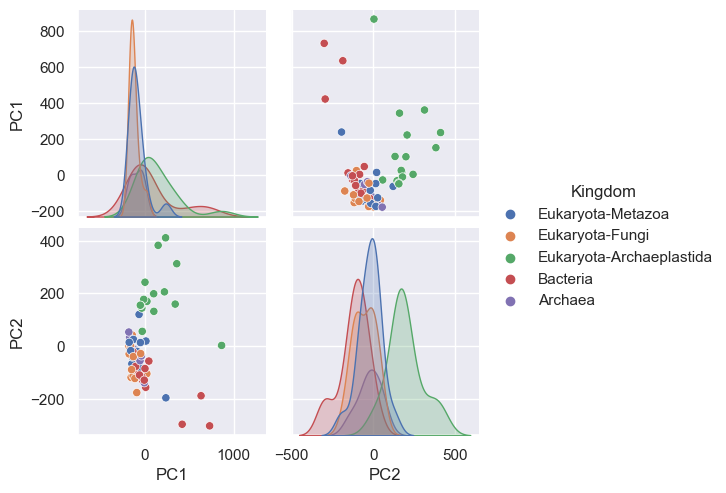

In [14]:
plt.figure(figsize=(10, 5))
sns.pairplot(pca_df, hue='Kingdom', vars=['PC1', 'PC2'])

<Axes: xlabel='Kingdom', ylabel='PC1'>

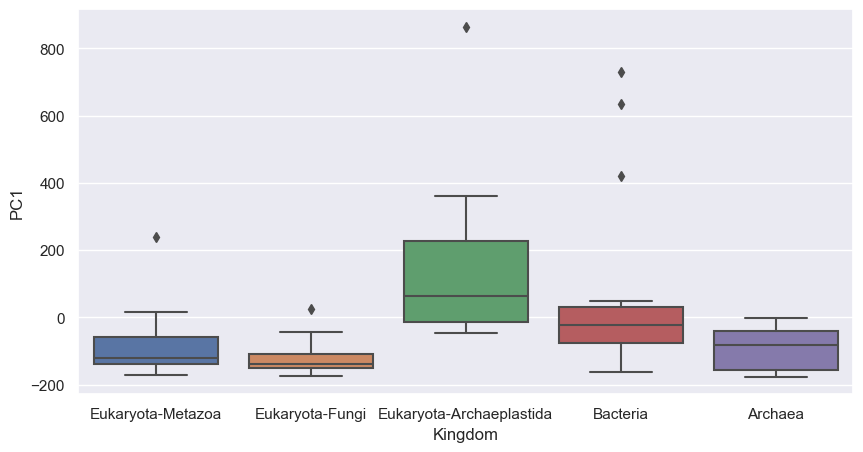

In [15]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=pca_df, x='Kingdom', y='PC1')

<Axes: xlabel='Kingdom', ylabel='PC2'>

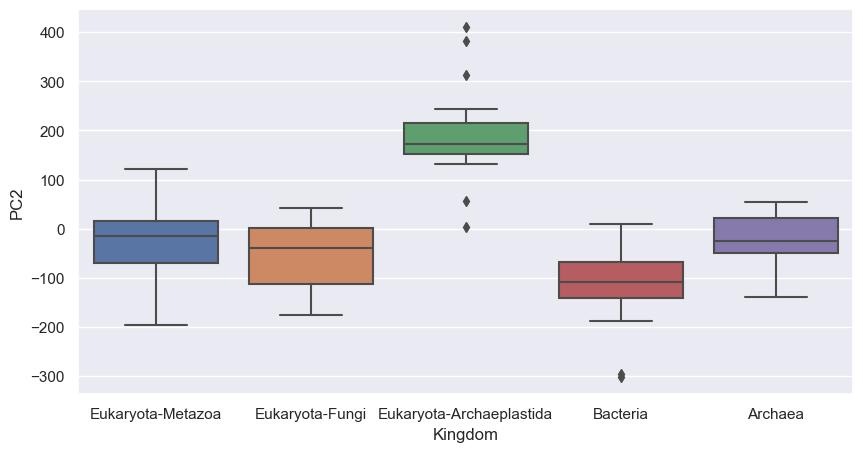

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=pca_df, x='Kingdom', y='PC2')

In [17]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey's test for PC1
tukey_pc1 = pairwise_tukeyhsd(endog=pca_df['PC1'], groups=pca_df['Kingdom'], alpha=0.005)
print(tukey_pc1)

# Run Tukey's test for PC2
tukey_pc2 = pairwise_tukeyhsd(endog=pca_df['PC2'], groups=pca_df['Kingdom'], alpha=0.005)
print(tukey_pc2)

                    Multiple Comparison of Means - Tukey HSD, FWER=0.01                     
         group1                   group2           meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------------------------
                 Archaea                 Bacteria  171.4602 0.3291  -156.872 499.7923  False
                 Archaea Eukaryota-Archaeplastida  234.2775 0.0796  -91.1098 559.6649  False
                 Archaea          Eukaryota-Fungi  -27.9153 0.9981 -363.3859 307.5554  False
                 Archaea        Eukaryota-Metazoa    6.6099    1.0 -318.7775 331.9973  False
                Bacteria Eukaryota-Archaeplastida   62.8174 0.8822 -181.4695 307.1043  False
                Bacteria          Eukaryota-Fungi -199.3754 0.0496 -456.9403  58.1895  False
                Bacteria        Eukaryota-Metazoa -164.8502 0.1152 -409.1372  79.4367  False
Eukaryota-Archaeplastida          Eukaryota-Fungi -262.1928 0.0034 -51